# plotting returns: comparing stocks with indices

Related: [Plotting a stock's price chart with corporate action overlay](https://github.com/stockviz/plutons/blob/master/charting-stocks-with-corporate-actions.R.ipynb)

In [1]:
library(DBI)
library(plutoDbR)
library(plutoR)
library(tidyverse)
options("scipen"=999)
options(stringsAsFactors = FALSE)
source("/usr/share/pluto/config.R")
source("/usr/share/pluto/goofy/plot.common.R")
source("/usr/share/pluto/goofy/misc.common.R")

library(ggthemes)
library(quantmod)
library(PerformanceAnalytics)

options(repr.plot.width=16, repr.plot.height=8)

#initialize
equitiesIndiaNse <- EquitiesIndiaNse()
indices <- Indices()

In [2]:
symbol <- "YESBANK"
indexName <- "NIFTY BANK TR"
startDt <- as.Date(Sys.Date() - 10*365) #10-year chart
endDt <- Sys.Date()

# examples: https://github.com/shyams80/plutons/blob/master/docs-R/EquitiesIndiaNse.ipynb

#make sure that the data exists

equitiesIndiaNse$EodTimeSeries() %>%
    filter(TIME_STAMP >= startDt & TIME_STAMP <= endDt 
           & SYMBOL == symbol 
           & (SERIES == 'EQ' | SERIES == 'BE')) %>%
    summarize(MAX_DT = max(TIME_STAMP), MIN_DT = min(TIME_STAMP)) %>%
    print()

equitiesIndiaNse$EodAdjustedTimeSeries() %>%
    filter(TIME_STAMP >= startDt & TIME_STAMP <= endDt 
           & SYMBOL == symbol) %>%
    summarize(MAX_DT = max(TIME_STAMP), MIN_DT = min(TIME_STAMP)) %>%
    print()


# Source:   lazy query [?? x 2]
# Database: NORWAY:StockViz:R
  MAX_DT     MIN_DT    
  <chr>      <chr>     
1 2019-09-12 2009-09-15
# Source:   lazy query [?? x 2]
# Database: SWEDEN:StockVizDyn:R
  MAX_DT     MIN_DT    
  <chr>      <chr>     
1 2019-09-09 2009-09-15


In [3]:
# so the data exists in both so we can use the EodAdjustedTimeSeries

eodPx <- equitiesIndiaNse$EodAdjustedTimeSeries() %>%
    filter(TIME_STAMP >= startDt & TIME_STAMP <= endDt & SYMBOL == symbol) %>%
    select(TIME_STAMP, CLOSE) %>%
    arrange(TIME_STAMP) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

indexPx <- indices$NseTimeSeries() %>%
    filter(NAME == indexName && TIME_STAMP >= startDt && TIME_STAMP <= endDt) %>%
    select(TIME_STAMP, CLOSE) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

dailies <- merge(dailyReturn(xts(eodPx$CLOSE, eodPx$TIME_STAMP)), 
                 dailyReturn(xts(indexPx$CLOSE,indexPx$TIME_STAMP)))

names(dailies) <- c(symbol, indexName)

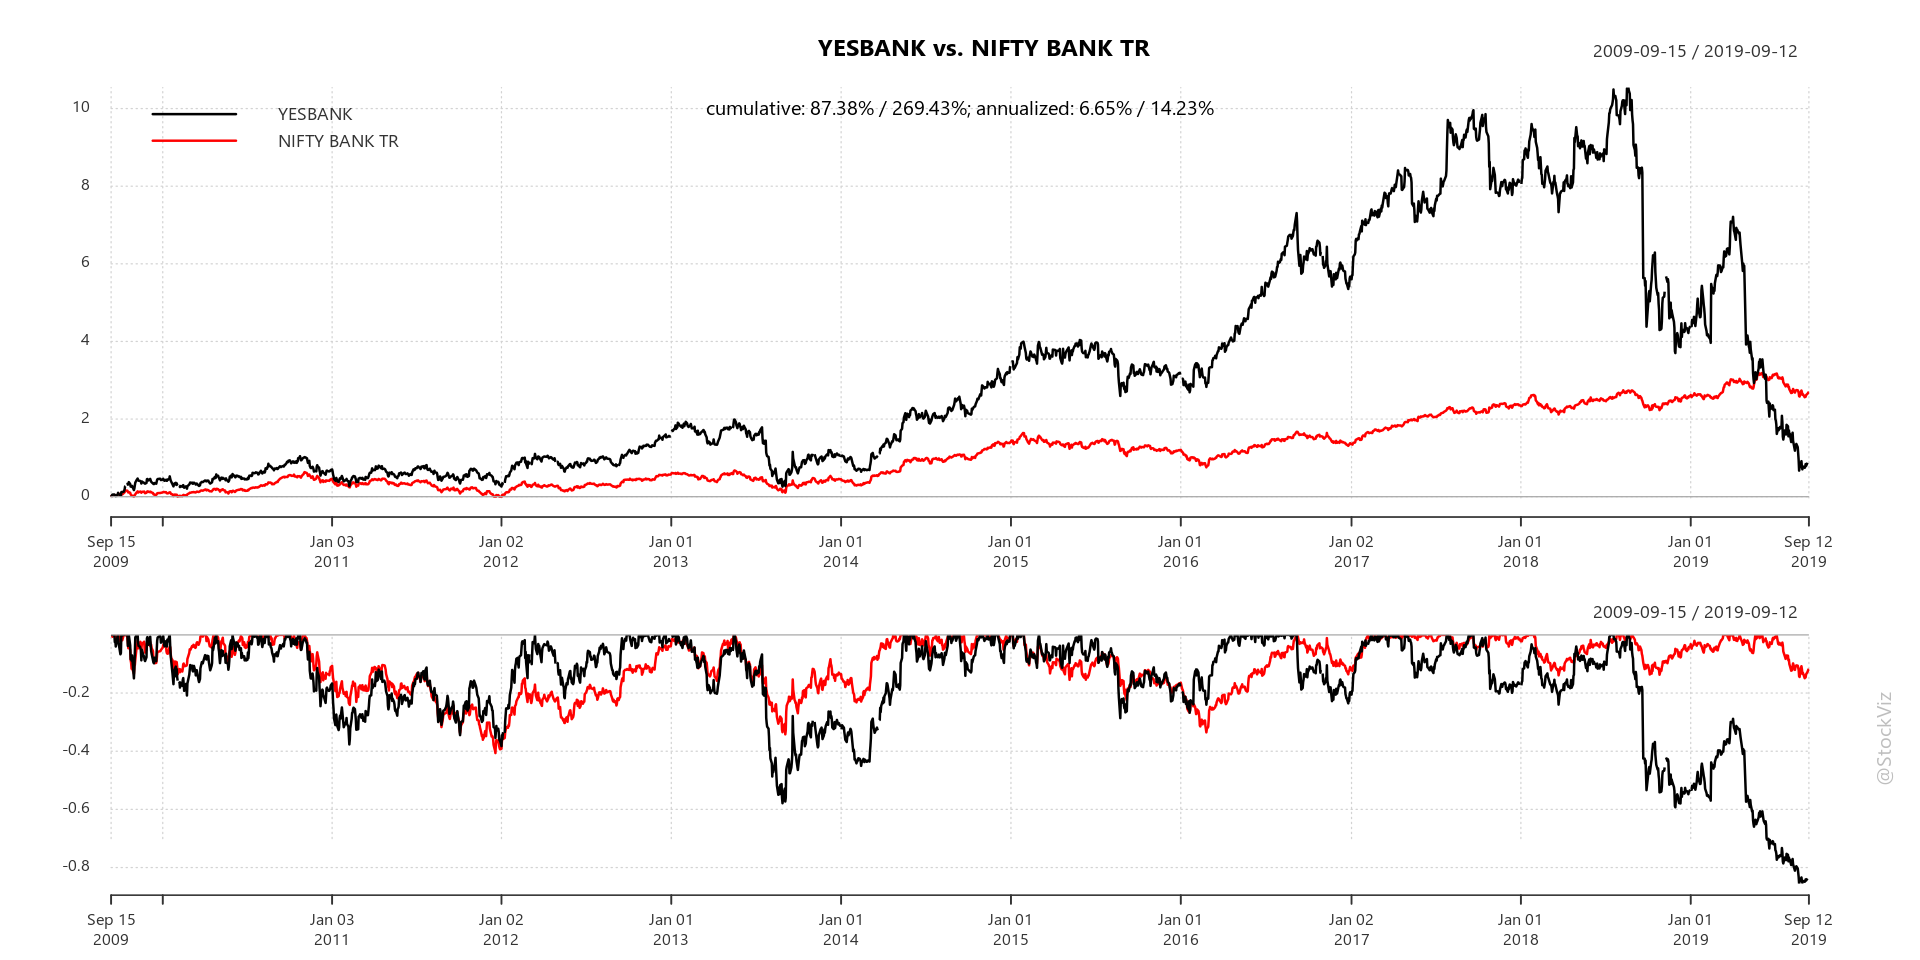

In [4]:
startDate <- first(index(dailies))
endDate <- last(index(dailies))

xAxisTicks <- seq(from=startDate, to=endDate, length.out=10)

Common.PlotCumReturns(dailies, sprintf("%s vs. %s", symbol, indexName), "")

This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)